<a href="/assets/tutorial06_example.ipynb" class="link-button">Download</a>
<a href="https://colab.research.google.com/github/technion046195/technion046195/blob/master/content/tutorial06/example.ipynb" target="_blank">
<img src="../assets/colab-badge.svg" style="display:inline"/>
</a>

<center><h1>
תרגול 10 - דוגמא מעשית
</h1></center>

## Setup

In [ ]:
## Importing packages
import os # A build in package for interacting with the OS. For example to create a folder.
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package
import imageio  # A package to read and write image (is used here to save gif images)
import tabulate  # A package from pretty printing tables
from graphviz import Digraph  # A package for plothing graphs (of nodes and edges)
import torch  ## importing PyTorch
import torch.optim as optim  ## Import the optimization module of the package
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import tqdm.notebook as tqdm

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

## Setting some nice matplotlib defaults
plt.rcParams['figure.figsize'] = (4.5, 4.5)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Auxiliary function for prining equations, pandas tables and images in cells output
from IPython.core.display import display, HTML, Latex, Markdown

## Create output folder
if not os.path.isdir('./output'):
    os.mkdir('./output')

## Data Inspection

In [ ]:
data_file = 'https://technion046195.netlify.app/datasets/voice.csv'

## Loading the data
dataset = pd.read_csv(data_file)

dataset

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female


### The Dataset Properties
Let us print the properties of the dataset along with the first few images

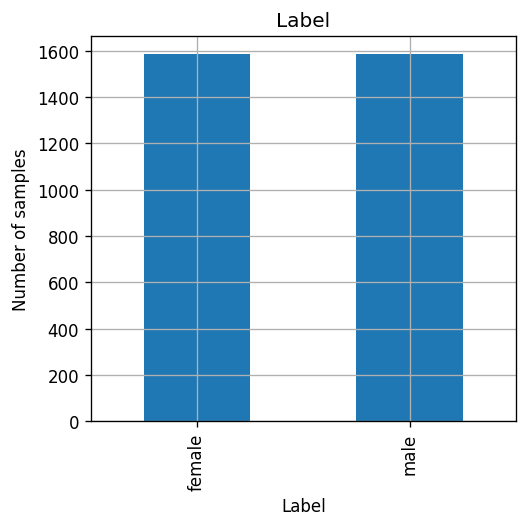

In [ ]:
fig, ax = plt.subplots()
dataset.groupby('label').size().plot.bar(ax=ax)
ax.set_title('Label')
ax.set_xlabel('Label')
ax.set_ylabel('Number of samples');
plt.tight_layout()

fig.savefig('./output/voices_labels_dist.png', dpi=240)

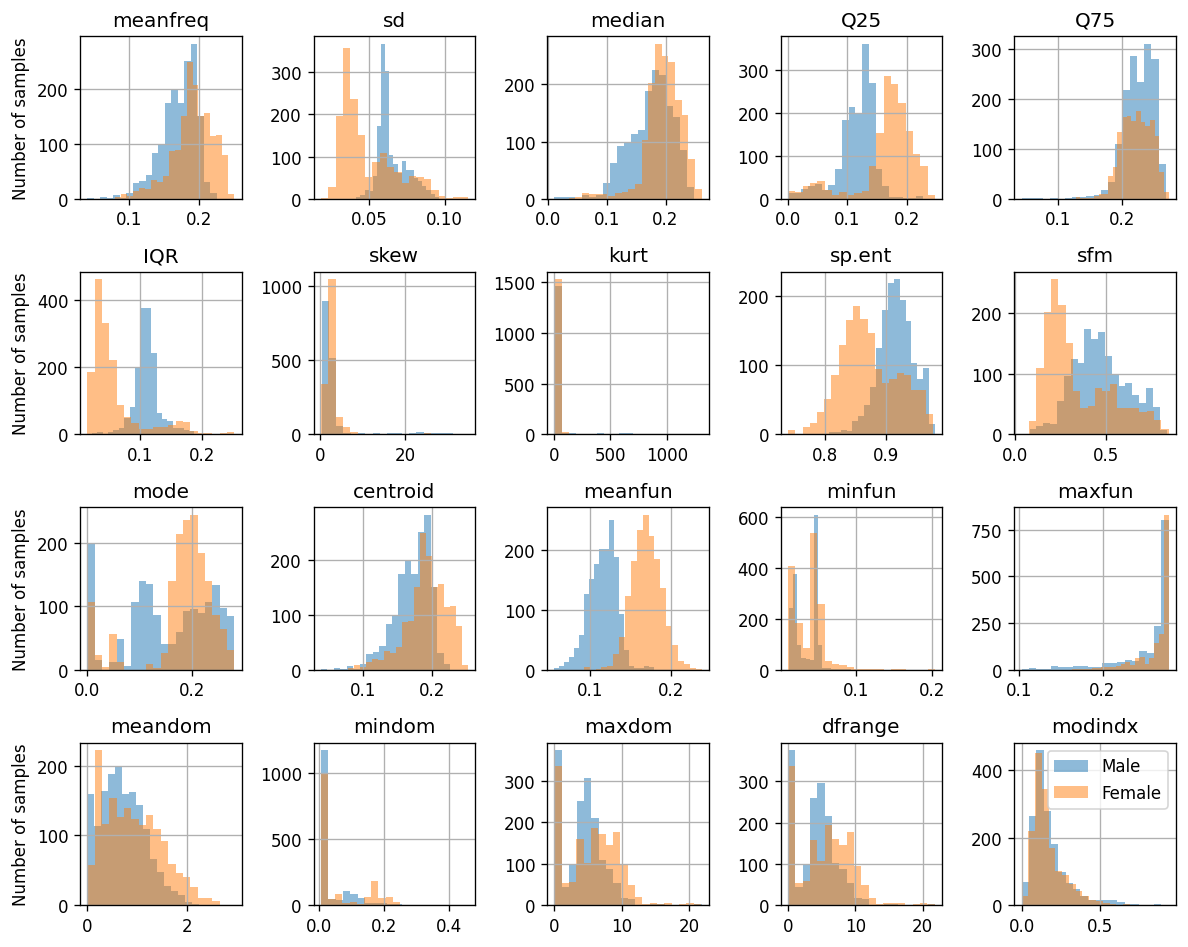

In [ ]:
measuements_columns = ['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx']

## Plotting the histograms
fig, ax_list = plt.subplots(4, 5, figsize=(10, 8))
for i, feature in enumerate(measuements_columns):
    ax = ax_list.flat[i]
    ax.hist(dataset.query('label == "male"')[feature].values, bins=20, alpha=0.5, label='Male')
    ax.hist(dataset.query('label == "female"')[feature].values, bins=20, alpha=0.5, label='Female')
    ax.set_title(feature)

for ax_list2 in ax_list:
    ax_list2[0].set_ylabel('Number of samples')
    
ax_list.flat[-1].legend()
plt.tight_layout()
fig.savefig('./output/voices_distributions.png', dpi=240)

## Train-Validation-Test split

In [ ]:
n_samples = len(dataset)

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(1)

## Generating a vector of indices
indices = np.arange(n_samples)

## Shuffle the indices
rand_gen.shuffle(indices)

## Split the indices into 60% train / 20% validation / 20% test
n_samples_train = int(n_samples * 0.6)
n_samples_val = int(n_samples * 0.2)
train_indices = indices[:n_samples_train]
val_indices = indices[n_samples_train:(n_samples_train + n_samples_val)]
test_indices = indices[(n_samples_train + n_samples_val):]

train_full_indices = np.concatenate((train_indices, val_indices))

train_full_set = dataset.iloc[train_full_indices]
train_set = dataset.iloc[train_indices]
val_set = dataset.iloc[val_indices]
test_set = dataset.iloc[test_indices]

In [ ]:
def extract_x_y(dataset):
    x = dataset[measuements_columns].values
    y = (dataset['label'].values == 'female') * 2 - 1
    return x, y

x_train_full, y_train_full = extract_x_y(train_full_set)
x_train, y_train = extract_x_y(train_set)
x_val, y_val = extract_x_y(val_set)
x_test, y_test = extract_x_y(test_set)

In [ ]:
from sklearn.svm import SVC

mean = x_train.mean(axis=0, keepdims=True)
std = x_train.std(axis=0, keepdims=True)

## Create the SVC object
svc = SVC(C = 1.0, kernel='linear')

## Run the learning algorithm
svc.fit((x_train - mean) / std, y_train)

## Evaluate in the test set
predictions = svc.predict((x_test - mean) / std)
test_risk = (y_test != predictions).mean()
print(f'The test risk is: {test_risk:.3}')

The test risk is: 0.0283


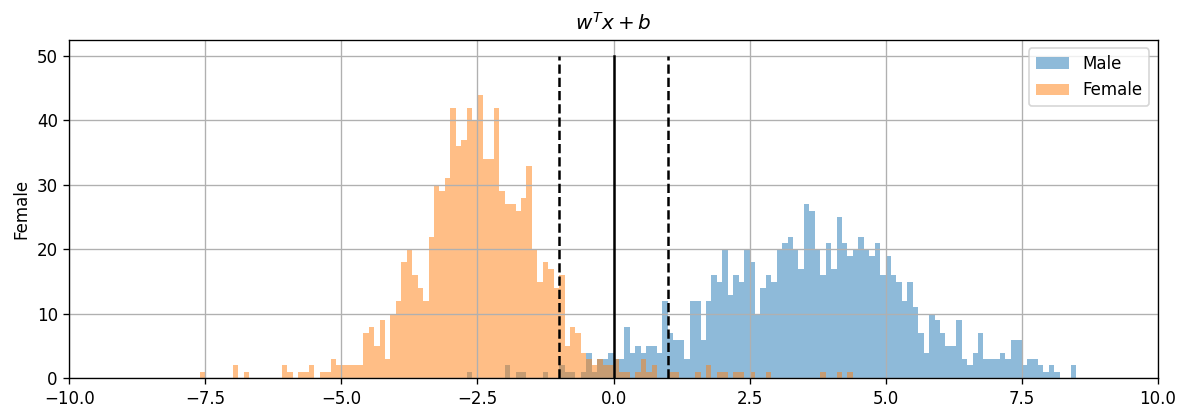

In [ ]:
dist = ((x_train - mean) / std) @ svc.coef_.T + svc.intercept_


fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_ylabel('Female')
ax.hist(dist[(y_train==1)], np.arange(-10, 10, 0.1), alpha=0.5, label='Male')
ax.hist(dist[(y_train==-1)], np.arange(-10, 10, 0.1), alpha=0.5, label='Female')
ax.plot([-1, -1], [0, 50], '--k')
ax.plot([0, 0], [0, 50], 'k')
ax.plot([1, 1], [0, 50], '--k')

ax.set_xlim(-10, 10)
ax.set_title('$w^Tx+b$')
ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.9])
fig.savefig('./output/voices_signed_dist.png', dpi=240)

The optimal C is 1.0
The test risk is: 0.022


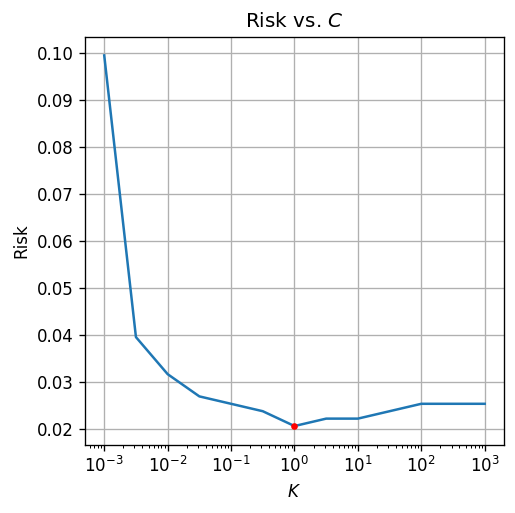

In [ ]:
## Define the list of C values to test
c_list = np.logspace(-3, 3, 13)

risk_array = np.zeros((len(c_list), ))

## Train and evaluate the algorithm for each C
for i_c, c in enumerate(c_list):
    svc = SVC(C=c, kernel='linear')
    svc.fit((x_train - mean) / std, y_train)
    
    predictions = svc.predict((x_val - mean) / std)
    risk_array[i_c] = (y_val != predictions).mean()

## Extract the optimal C value
optimal_index = np.argmin(risk_array)
optimal_c = c_list[optimal_index]

print(f'The optimal C is {optimal_c}')

## Re-learn and evalute the model with the optimal C
svc = SVC(C = optimal_c, kernel='linear')
svc.fit((x_train_full - mean) / std, y_train_full)
predictions = svc.predict((x_test - mean) / std)
test_risk = (y_test != predictions).mean()
print(f'The test risk is: {test_risk:.2}')

## PLot risk vs. C
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(c_list, risk_array)
ax.plot(optimal_c, risk_array[optimal_index], '.r')
ax.set_xlabel('$K$')
ax.set_ylabel('Risk')
ax.set_title('Risk vs. $C$');

fig.savefig('./output/voices_selecting_c.png', dpi=240)